# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.16878229  0.97923069 -0.23229453 -1.61358252] 0 1.0 True {}
state, action, reward, done, info
[-0.12531558 -0.56343405  0.21753117  1.20850904] 1 1.0 True {}
state, action, reward, done, info
[ 0.09763954  0.98484416 -0.23493942 -1.81669763] 1 1.0 True {}
state, action, reward, done, info
[ 0.23651698  1.21661112 -0.23003575 -1.72874742] 1 1.0 True {}
state, action, reward, done, info
[-0.07476237 -0.99618288  0.21585503  1.75200379] 0 1.0 True {}
state, action, reward, done, info
[ 0.18447555  0.77859747 -0.23168753 -1.35706505] 0 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [16]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [17]:
def generator(states, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.1 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.1 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [18]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    outputs = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(outputs, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return outputs, Qs, loss

In [19]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.outputs, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [20]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [22]:
tf.reset_default_graph()
mainQN = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [23]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {mainQN.states: state.reshape((1, *state.shape))}
                targetQ = sess.run(mainQN.outputs, feed_dict)
                action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_targetQs = sess.run(mainQN.outputs, feed_dict={mainQN.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_targetQs[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_targetQs, axis=1))

            # Updating the model
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.states: states,
                                           mainQN.targetQs: targetQs,
                                           mainQN.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 11.0 Training loss: 1.2004 Explore P: 0.9989
Episode: 1 Total reward: 10.0 Training loss: 1.2793 Explore P: 0.9979
Episode: 2 Total reward: 13.0 Training loss: 1.4612 Explore P: 0.9966
Episode: 3 Total reward: 26.0 Training loss: 1.9952 Explore P: 0.9941
Episode: 4 Total reward: 9.0 Training loss: 2.7353 Explore P: 0.9932
Episode: 5 Total reward: 11.0 Training loss: 5.2569 Explore P: 0.9921
Episode: 6 Total reward: 10.0 Training loss: 7.9383 Explore P: 0.9911
Episode: 7 Total reward: 20.0 Training loss: 8.0427 Explore P: 0.9892
Episode: 8 Total reward: 23.0 Training loss: 50.1171 Explore P: 0.9869
Episode: 9 Total reward: 38.0 Training loss: 130.5681 Explore P: 0.9832
Episode: 10 Total reward: 24.0 Training loss: 425.7245 Explore P: 0.9809
Episode: 11 Total reward: 18.0 Training loss: 363.4439 Explore P: 0.9791
Episode: 12 Total reward: 16.0 Training loss: 13.8281 Explore P: 0.9776
Episode: 13 Total reward: 47.0 Training loss: 1.4278 Explore P: 0.9730
Episode: 

Episode: 114 Total reward: 71.0 Training loss: 77.9969 Explore P: 0.7619
Episode: 115 Total reward: 27.0 Training loss: 10.3578 Explore P: 0.7599
Episode: 116 Total reward: 13.0 Training loss: 49.6217 Explore P: 0.7589
Episode: 117 Total reward: 36.0 Training loss: 94.3128 Explore P: 0.7562
Episode: 118 Total reward: 70.0 Training loss: 27.9300 Explore P: 0.7510
Episode: 119 Total reward: 47.0 Training loss: 234.1109 Explore P: 0.7475
Episode: 120 Total reward: 52.0 Training loss: 208.9832 Explore P: 0.7437
Episode: 121 Total reward: 44.0 Training loss: 104.9633 Explore P: 0.7405
Episode: 122 Total reward: 50.0 Training loss: 134.8995 Explore P: 0.7368
Episode: 123 Total reward: 29.0 Training loss: 19.0880 Explore P: 0.7347
Episode: 124 Total reward: 28.0 Training loss: 206.1370 Explore P: 0.7327
Episode: 125 Total reward: 13.0 Training loss: 13.1063 Explore P: 0.7318
Episode: 126 Total reward: 24.0 Training loss: 69.6706 Explore P: 0.7300
Episode: 127 Total reward: 38.0 Training loss:

Episode: 224 Total reward: 150.0 Training loss: 191.4855 Explore P: 0.2363
Episode: 225 Total reward: 199.0 Training loss: 159.4574 Explore P: 0.2319
Episode: 226 Total reward: 182.0 Training loss: 259.5484 Explore P: 0.2279
Episode: 227 Total reward: 199.0 Training loss: 51.0468 Explore P: 0.2236
Episode: 228 Total reward: 171.0 Training loss: 87.8091 Explore P: 0.2200
Episode: 229 Total reward: 199.0 Training loss: 146.8006 Explore P: 0.2158
Episode: 230 Total reward: 199.0 Training loss: 48.7238 Explore P: 0.2118
Episode: 231 Total reward: 199.0 Training loss: 71.3766 Explore P: 0.2078
Episode: 232 Total reward: 189.0 Training loss: 59.3786 Explore P: 0.2041
Episode: 233 Total reward: 134.0 Training loss: 41.6524 Explore P: 0.2015
Episode: 234 Total reward: 199.0 Training loss: 47.5554 Explore P: 0.1977
Episode: 235 Total reward: 199.0 Training loss: 306.6441 Explore P: 0.1940
Episode: 236 Total reward: 177.0 Training loss: 53.2770 Explore P: 0.1908
Episode: 237 Total reward: 199.0 

Episode: 336 Total reward: 9.0 Training loss: 99.8314 Explore P: 0.0764
Episode: 337 Total reward: 11.0 Training loss: 145.5658 Explore P: 0.0763
Episode: 338 Total reward: 10.0 Training loss: 343.4731 Explore P: 0.0762
Episode: 339 Total reward: 11.0 Training loss: 400.4745 Explore P: 0.0761
Episode: 340 Total reward: 8.0 Training loss: 292.5768 Explore P: 0.0761
Episode: 341 Total reward: 12.0 Training loss: 325.7415 Explore P: 0.0760
Episode: 342 Total reward: 10.0 Training loss: 543.7342 Explore P: 0.0759
Episode: 343 Total reward: 14.0 Training loss: 291.7144 Explore P: 0.0759
Episode: 344 Total reward: 91.0 Training loss: 505.6083 Explore P: 0.0753
Episode: 345 Total reward: 199.0 Training loss: 320.4977 Explore P: 0.0740
Episode: 346 Total reward: 192.0 Training loss: 653.2523 Explore P: 0.0728
Episode: 347 Total reward: 186.0 Training loss: 4979.2817 Explore P: 0.0716
Episode: 348 Total reward: 161.0 Training loss: 163.5857 Explore P: 0.0706
Episode: 349 Total reward: 199.0 Tra

Episode: 448 Total reward: 15.0 Training loss: 407.3891 Explore P: 0.0331
Episode: 449 Total reward: 11.0 Training loss: 3929.4019 Explore P: 0.0331
Episode: 450 Total reward: 111.0 Training loss: 1287.0909 Explore P: 0.0329
Episode: 451 Total reward: 199.0 Training loss: 150.8461 Explore P: 0.0324
Episode: 452 Total reward: 199.0 Training loss: 108.2170 Explore P: 0.0320
Episode: 453 Total reward: 199.0 Training loss: 86.1438 Explore P: 0.0315
Episode: 454 Total reward: 199.0 Training loss: 143.7525 Explore P: 0.0311
Episode: 455 Total reward: 199.0 Training loss: 400.1960 Explore P: 0.0307
Episode: 456 Total reward: 199.0 Training loss: 60.0710 Explore P: 0.0303
Episode: 457 Total reward: 199.0 Training loss: 39.5226 Explore P: 0.0299
Episode: 458 Total reward: 199.0 Training loss: 91.4825 Explore P: 0.0295
Episode: 459 Total reward: 199.0 Training loss: 119.0769 Explore P: 0.0291
Episode: 460 Total reward: 199.0 Training loss: 54.4233 Explore P: 0.0287
Episode: 461 Total reward: 199

Episode: 560 Total reward: 165.0 Training loss: 187.2192 Explore P: 0.0129
Episode: 561 Total reward: 199.0 Training loss: 3.0016 Explore P: 0.0128
Episode: 562 Total reward: 199.0 Training loss: 2.4424 Explore P: 0.0127
Episode: 563 Total reward: 198.0 Training loss: 7.3122 Explore P: 0.0127
Episode: 564 Total reward: 199.0 Training loss: 2.6814 Explore P: 0.0126
Episode: 565 Total reward: 199.0 Training loss: 4.6322 Explore P: 0.0126
Episode: 566 Total reward: 199.0 Training loss: 3.0194 Explore P: 0.0125
Episode: 567 Total reward: 199.0 Training loss: 22.6166 Explore P: 0.0125
Episode: 568 Total reward: 132.0 Training loss: 1.9474 Explore P: 0.0125
Episode: 569 Total reward: 199.0 Training loss: 4.5010 Explore P: 0.0124
Episode: 570 Total reward: 168.0 Training loss: 2.5125 Explore P: 0.0124
Episode: 571 Total reward: 199.0 Training loss: 1.6228 Explore P: 0.0123
Episode: 572 Total reward: 199.0 Training loss: 2.8266 Explore P: 0.0123
Episode: 573 Total reward: 159.0 Training loss: 

Episode: 672 Total reward: 14.0 Training loss: 2817.9622 Explore P: 0.0114
Episode: 673 Total reward: 40.0 Training loss: 22533.8164 Explore P: 0.0114
Episode: 674 Total reward: 119.0 Training loss: 1422.6665 Explore P: 0.0114
Episode: 675 Total reward: 19.0 Training loss: 4475.4819 Explore P: 0.0114
Episode: 676 Total reward: 17.0 Training loss: 3108.7639 Explore P: 0.0114
Episode: 677 Total reward: 16.0 Training loss: 214.7656 Explore P: 0.0114
Episode: 678 Total reward: 17.0 Training loss: 1213.1364 Explore P: 0.0114
Episode: 679 Total reward: 14.0 Training loss: 6198.7964 Explore P: 0.0114
Episode: 680 Total reward: 15.0 Training loss: 2227.5933 Explore P: 0.0114
Episode: 681 Total reward: 14.0 Training loss: 6086.3560 Explore P: 0.0113
Episode: 682 Total reward: 13.0 Training loss: 593.0236 Explore P: 0.0113
Episode: 683 Total reward: 11.0 Training loss: 3035.3665 Explore P: 0.0113
Episode: 684 Total reward: 13.0 Training loss: 6435.1035 Explore P: 0.0113
Episode: 685 Total reward

Episode: 783 Total reward: 173.0 Training loss: 5.7290 Explore P: 0.0106
Episode: 784 Total reward: 38.0 Training loss: 7.0042 Explore P: 0.0105
Episode: 785 Total reward: 68.0 Training loss: 9.8781 Explore P: 0.0105
Episode: 786 Total reward: 136.0 Training loss: 3.9165 Explore P: 0.0105
Episode: 787 Total reward: 64.0 Training loss: 10.4330 Explore P: 0.0105
Episode: 788 Total reward: 43.0 Training loss: 7.1280 Explore P: 0.0105
Episode: 789 Total reward: 74.0 Training loss: 35.1709 Explore P: 0.0105
Episode: 790 Total reward: 94.0 Training loss: 8.0489 Explore P: 0.0105
Episode: 791 Total reward: 98.0 Training loss: 7.4119 Explore P: 0.0105
Episode: 792 Total reward: 183.0 Training loss: 3.3731 Explore P: 0.0105
Episode: 793 Total reward: 116.0 Training loss: 4.8947 Explore P: 0.0105
Episode: 794 Total reward: 81.0 Training loss: 4.4985 Explore P: 0.0105
Episode: 795 Total reward: 56.0 Training loss: 24.3649 Explore P: 0.0105
Episode: 796 Total reward: 73.0 Training loss: 151.5909 E

Episode: 895 Total reward: 134.0 Training loss: 175.6402 Explore P: 0.0102
Episode: 896 Total reward: 199.0 Training loss: 115.1956 Explore P: 0.0102
Episode: 897 Total reward: 108.0 Training loss: 49.5716 Explore P: 0.0102
Episode: 898 Total reward: 106.0 Training loss: 74.1466 Explore P: 0.0102
Episode: 899 Total reward: 122.0 Training loss: 110.8867 Explore P: 0.0102
Episode: 900 Total reward: 112.0 Training loss: 103.1244 Explore P: 0.0102
Episode: 901 Total reward: 199.0 Training loss: 40.4628 Explore P: 0.0102
Episode: 902 Total reward: 114.0 Training loss: 622.7189 Explore P: 0.0102
Episode: 903 Total reward: 199.0 Training loss: 1597.4292 Explore P: 0.0102
Episode: 904 Total reward: 120.0 Training loss: 19.5675 Explore P: 0.0102
Episode: 905 Total reward: 124.0 Training loss: 40.5946 Explore P: 0.0102
Episode: 906 Total reward: 199.0 Training loss: 16.4279 Explore P: 0.0102
Episode: 907 Total reward: 149.0 Training loss: 24.9795 Explore P: 0.0102
Episode: 908 Total reward: 134.

Episode: 1006 Total reward: 9.0 Training loss: 4675.1650 Explore P: 0.0100
Episode: 1007 Total reward: 10.0 Training loss: 5405.3555 Explore P: 0.0100
Episode: 1008 Total reward: 10.0 Training loss: 2831.3389 Explore P: 0.0100
Episode: 1009 Total reward: 19.0 Training loss: 3186.0461 Explore P: 0.0100
Episode: 1010 Total reward: 14.0 Training loss: 2116.4863 Explore P: 0.0100
Episode: 1011 Total reward: 98.0 Training loss: 486.1192 Explore P: 0.0100
Episode: 1012 Total reward: 8.0 Training loss: 4887.0562 Explore P: 0.0100
Episode: 1013 Total reward: 8.0 Training loss: 2734.8887 Explore P: 0.0100
Episode: 1014 Total reward: 12.0 Training loss: 2784.5205 Explore P: 0.0100
Episode: 1015 Total reward: 11.0 Training loss: 4851.3838 Explore P: 0.0100
Episode: 1016 Total reward: 7.0 Training loss: 1404.5930 Explore P: 0.0100
Episode: 1017 Total reward: 10.0 Training loss: 740.6389 Explore P: 0.0100
Episode: 1018 Total reward: 11.0 Training loss: 6785.9829 Explore P: 0.0100
Episode: 1019 Tota

Episode: 1115 Total reward: 199.0 Training loss: 1.3832 Explore P: 0.0100
Episode: 1116 Total reward: 199.0 Training loss: 3.5864 Explore P: 0.0100
Episode: 1117 Total reward: 199.0 Training loss: 3.4691 Explore P: 0.0100
Episode: 1118 Total reward: 199.0 Training loss: 3.9734 Explore P: 0.0100
Episode: 1119 Total reward: 199.0 Training loss: 0.8992 Explore P: 0.0100
Episode: 1120 Total reward: 199.0 Training loss: 3.1645 Explore P: 0.0100
Episode: 1121 Total reward: 199.0 Training loss: 1.0107 Explore P: 0.0100
Episode: 1122 Total reward: 199.0 Training loss: 0.5504 Explore P: 0.0100
Episode: 1123 Total reward: 199.0 Training loss: 0.4751 Explore P: 0.0100
Episode: 1124 Total reward: 159.0 Training loss: 1.0474 Explore P: 0.0100
Episode: 1125 Total reward: 199.0 Training loss: 1.3998 Explore P: 0.0100
Episode: 1126 Total reward: 199.0 Training loss: 0.4991 Explore P: 0.0100
Episode: 1127 Total reward: 199.0 Training loss: 0.9303 Explore P: 0.0100
Episode: 1128 Total reward: 199.0 Trai

Episode: 1226 Total reward: 199.0 Training loss: 0.1355 Explore P: 0.0100
Episode: 1227 Total reward: 199.0 Training loss: 0.7744 Explore P: 0.0100
Episode: 1228 Total reward: 199.0 Training loss: 1.1222 Explore P: 0.0100
Episode: 1229 Total reward: 199.0 Training loss: 0.3288 Explore P: 0.0100
Episode: 1230 Total reward: 199.0 Training loss: 2.0629 Explore P: 0.0100
Episode: 1231 Total reward: 199.0 Training loss: 0.4012 Explore P: 0.0100
Episode: 1232 Total reward: 199.0 Training loss: 4.6089 Explore P: 0.0100
Episode: 1233 Total reward: 199.0 Training loss: 1.0636 Explore P: 0.0100
Episode: 1234 Total reward: 199.0 Training loss: 1.0766 Explore P: 0.0100
Episode: 1235 Total reward: 199.0 Training loss: 2.6569 Explore P: 0.0100
Episode: 1236 Total reward: 199.0 Training loss: 0.5365 Explore P: 0.0100
Episode: 1237 Total reward: 199.0 Training loss: 49.1991 Explore P: 0.0100
Episode: 1238 Total reward: 199.0 Training loss: 1.2215 Explore P: 0.0100
Episode: 1239 Total reward: 199.0 Tra

Episode: 1336 Total reward: 199.0 Training loss: 12.4378 Explore P: 0.0100
Episode: 1337 Total reward: 199.0 Training loss: 20.4105 Explore P: 0.0100
Episode: 1338 Total reward: 199.0 Training loss: 26.9909 Explore P: 0.0100
Episode: 1339 Total reward: 199.0 Training loss: 5.9093 Explore P: 0.0100
Episode: 1340 Total reward: 199.0 Training loss: 8.3872 Explore P: 0.0100
Episode: 1341 Total reward: 199.0 Training loss: 35.0295 Explore P: 0.0100
Episode: 1342 Total reward: 199.0 Training loss: 533.1824 Explore P: 0.0100
Episode: 1343 Total reward: 199.0 Training loss: 19.6484 Explore P: 0.0100
Episode: 1344 Total reward: 199.0 Training loss: 215.8800 Explore P: 0.0100
Episode: 1345 Total reward: 199.0 Training loss: 6.6533 Explore P: 0.0100
Episode: 1346 Total reward: 199.0 Training loss: 786.2994 Explore P: 0.0100
Episode: 1347 Total reward: 199.0 Training loss: 7.7957 Explore P: 0.0100
Episode: 1348 Total reward: 199.0 Training loss: 6.8376 Explore P: 0.0100
Episode: 1349 Total reward:

Episode: 1446 Total reward: 199.0 Training loss: 187.7228 Explore P: 0.0100
Episode: 1447 Total reward: 199.0 Training loss: 45392.6133 Explore P: 0.0100
Episode: 1448 Total reward: 199.0 Training loss: 77.4920 Explore P: 0.0100
Episode: 1449 Total reward: 199.0 Training loss: 4504.0796 Explore P: 0.0100
Episode: 1450 Total reward: 199.0 Training loss: 248.6812 Explore P: 0.0100
Episode: 1451 Total reward: 199.0 Training loss: 176.2023 Explore P: 0.0100
Episode: 1452 Total reward: 199.0 Training loss: 94.6490 Explore P: 0.0100
Episode: 1453 Total reward: 199.0 Training loss: 2819.5796 Explore P: 0.0100
Episode: 1454 Total reward: 199.0 Training loss: 3053.4534 Explore P: 0.0100
Episode: 1455 Total reward: 199.0 Training loss: 37.9897 Explore P: 0.0100
Episode: 1456 Total reward: 199.0 Training loss: 14.6199 Explore P: 0.0100
Episode: 1457 Total reward: 199.0 Training loss: 39.2749 Explore P: 0.0100
Episode: 1458 Total reward: 199.0 Training loss: 1006.6647 Explore P: 0.0100
Episode: 14

Episode: 1556 Total reward: 199.0 Training loss: 10.8053 Explore P: 0.0100
Episode: 1557 Total reward: 199.0 Training loss: 10.0313 Explore P: 0.0100
Episode: 1558 Total reward: 199.0 Training loss: 5.4132 Explore P: 0.0100
Episode: 1559 Total reward: 199.0 Training loss: 2.5479 Explore P: 0.0100
Episode: 1560 Total reward: 199.0 Training loss: 59.3358 Explore P: 0.0100
Episode: 1561 Total reward: 199.0 Training loss: 6.7244 Explore P: 0.0100
Episode: 1562 Total reward: 199.0 Training loss: 4.0242 Explore P: 0.0100
Episode: 1563 Total reward: 199.0 Training loss: 4.9934 Explore P: 0.0100
Episode: 1564 Total reward: 143.0 Training loss: 2.8471 Explore P: 0.0100
Episode: 1565 Total reward: 199.0 Training loss: 6.7792 Explore P: 0.0100
Episode: 1566 Total reward: 199.0 Training loss: 124.9082 Explore P: 0.0100
Episode: 1567 Total reward: 199.0 Training loss: 13.9016 Explore P: 0.0100
Episode: 1568 Total reward: 199.0 Training loss: 12.3312 Explore P: 0.0100
Episode: 1569 Total reward: 199

Episode: 1664 Total reward: 11.0 Training loss: 119998.6875 Explore P: 0.0100
Episode: 1665 Total reward: 8.0 Training loss: 143579.9062 Explore P: 0.0100
Episode: 1666 Total reward: 7.0 Training loss: 64214.2812 Explore P: 0.0100
Episode: 1667 Total reward: 10.0 Training loss: 126689.3750 Explore P: 0.0100
Episode: 1668 Total reward: 11.0 Training loss: 28176.5273 Explore P: 0.0100
Episode: 1669 Total reward: 10.0 Training loss: 168756.6562 Explore P: 0.0100
Episode: 1670 Total reward: 11.0 Training loss: 91297.7344 Explore P: 0.0100
Episode: 1671 Total reward: 9.0 Training loss: 4579227.5000 Explore P: 0.0100
Episode: 1672 Total reward: 7.0 Training loss: 149387.0938 Explore P: 0.0100
Episode: 1673 Total reward: 11.0 Training loss: 24881972.0000 Explore P: 0.0100
Episode: 1674 Total reward: 10.0 Training loss: 88236.4375 Explore P: 0.0100
Episode: 1675 Total reward: 9.0 Training loss: 129110.3750 Explore P: 0.0100
Episode: 1676 Total reward: 8.0 Training loss: 91386.0391 Explore P: 0

Episode: 1770 Total reward: 57.0 Training loss: 25048.1992 Explore P: 0.0100
Episode: 1771 Total reward: 86.0 Training loss: 57025.2734 Explore P: 0.0100
Episode: 1772 Total reward: 91.0 Training loss: 29090.2812 Explore P: 0.0100
Episode: 1773 Total reward: 109.0 Training loss: 77575.7031 Explore P: 0.0100
Episode: 1774 Total reward: 129.0 Training loss: 40267.4688 Explore P: 0.0100
Episode: 1775 Total reward: 199.0 Training loss: 19259.1387 Explore P: 0.0100
Episode: 1776 Total reward: 199.0 Training loss: 14203.1504 Explore P: 0.0100
Episode: 1777 Total reward: 199.0 Training loss: 16147.7607 Explore P: 0.0100
Episode: 1778 Total reward: 199.0 Training loss: 26569.1465 Explore P: 0.0100
Episode: 1779 Total reward: 199.0 Training loss: 12092.6777 Explore P: 0.0100
Episode: 1780 Total reward: 199.0 Training loss: 7136.3281 Explore P: 0.0100
Episode: 1781 Total reward: 199.0 Training loss: 401069.4688 Explore P: 0.0100
Episode: 1782 Total reward: 199.0 Training loss: 79547.3594 Explore

Episode: 1876 Total reward: 57.0 Training loss: 46743.5820 Explore P: 0.0100
Episode: 1877 Total reward: 38.0 Training loss: 225530.9219 Explore P: 0.0100
Episode: 1878 Total reward: 30.0 Training loss: 16923.0508 Explore P: 0.0100
Episode: 1879 Total reward: 26.0 Training loss: 55921.7383 Explore P: 0.0100
Episode: 1880 Total reward: 24.0 Training loss: 54338.8945 Explore P: 0.0100
Episode: 1881 Total reward: 21.0 Training loss: 55089.6367 Explore P: 0.0100
Episode: 1882 Total reward: 19.0 Training loss: 144796.8906 Explore P: 0.0100
Episode: 1883 Total reward: 20.0 Training loss: 43499.0625 Explore P: 0.0100
Episode: 1884 Total reward: 17.0 Training loss: 27588.6562 Explore P: 0.0100
Episode: 1885 Total reward: 12.0 Training loss: 606663.1875 Explore P: 0.0100
Episode: 1886 Total reward: 14.0 Training loss: 78056.7109 Explore P: 0.0100
Episode: 1887 Total reward: 11.0 Training loss: 129859.4766 Explore P: 0.0100
Episode: 1888 Total reward: 12.0 Training loss: 40483.8125 Explore P: 0.

Episode: 1982 Total reward: 128.0 Training loss: 1357.5426 Explore P: 0.0100
Episode: 1983 Total reward: 133.0 Training loss: 750.6181 Explore P: 0.0100
Episode: 1984 Total reward: 130.0 Training loss: 632.1508 Explore P: 0.0100
Episode: 1985 Total reward: 134.0 Training loss: 8899.3496 Explore P: 0.0100
Episode: 1986 Total reward: 199.0 Training loss: 472.5023 Explore P: 0.0100
Episode: 1987 Total reward: 199.0 Training loss: 1080.3301 Explore P: 0.0100
Episode: 1988 Total reward: 199.0 Training loss: 92393.0000 Explore P: 0.0100
Episode: 1989 Total reward: 199.0 Training loss: 4769209.0000 Explore P: 0.0100
Episode: 1990 Total reward: 11.0 Training loss: 1022012.3750 Explore P: 0.0100
Episode: 1991 Total reward: 10.0 Training loss: 1444381.6250 Explore P: 0.0100
Episode: 1992 Total reward: 9.0 Training loss: 71579288.0000 Explore P: 0.0100
Episode: 1993 Total reward: 9.0 Training loss: 1274600.2500 Explore P: 0.0100
Episode: 1994 Total reward: 9.0 Training loss: 1117569.2500 Explore 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

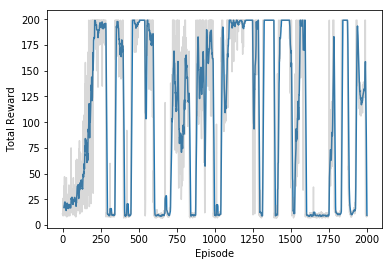

In [25]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed_dict = {mainQN.states: state.reshape((1, *state.shape))}
            targetQ = sess.run(mainQN.outputs, feed_dict)
            action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.